## 0. 필요 모듈 import

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 한글폰트 설정, 그래프 마이너스 표시 설정
import matplotlib
from matplotlib import font_manager,rc
from matplotlib import pyplot as plt
import platform
import seaborn as sns

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## 1. 데이터 불러오기

In [42]:
df_org = pd.read_csv('final서울대공원1019.csv', encoding='cp949')
df_org = df_org.drop(['Unnamed: 0'], axis=1)
df_org = df_org.drop(['일자'], axis=1)
df_org = df_org.set_index('date')
df = df_org.copy()
df.head()

,요일,Daily_Total,Holiday,승차총승객수,하차총승객수,네비게이션,최고기온(℃),최저기온(℃),평균풍속(m/s),최대풍속(m/s),PM2.5,PM10,강수량(mm),행사
date,,,,,,,,,,,,,,
2018-01-01,1,2316,1,2583,2559,175,3.8,-5.1,1.4,3.8,22,39,0.0,0
2018-01-02,2,988,0,3386,3637,82,1.8,-4.3,1.8,4.9,21,35,0.0,0
2018-01-03,3,694,0,2867,3075,50,-0.4,-7.1,2.2,3.5,20,32,0.0,0
2018-01-04,4,671,0,2739,2938,58,-0.7,-8.7,1.4,3.5,27,42,0.0,0
2018-01-05,5,758,0,2985,3148,61,1.6,-5.6,1.7,3.6,34,47,0.0,0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1642 entries, 2018-01-01 to 2022-06-30
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   요일           1642 non-null   int64  
 1   Daily_Total  1642 non-null   int64  
 2   Holiday      1642 non-null   int64  
 3   승차총승객수       1642 non-null   int64  
 4   하차총승객수       1642 non-null   int64  
 5   네비게이션        1642 non-null   int64  
 6   최고기온(℃)      1642 non-null   float64
 7   최저기온(℃)      1642 non-null   float64
 8   평균풍속(m/s)    1642 non-null   float64
 9   최대풍속(m/s)    1642 non-null   float64
 10  PM2.5        1642 non-null   int64  
 11  PM10         1642 non-null   int64  
 12  강수량(mm)      1642 non-null   float64
 13  행사           1642 non-null   int64  
dtypes: float64(5), int64(9)
memory usage: 192.4+ KB


## 2. 데이터 탐색

### 2.1. 타겟값 로그변환

<AxesSubplot:title={'center':'Original 서울대공원 일일 방문객 Histogram'}, xlabel='Daily_Total', ylabel='Density'>

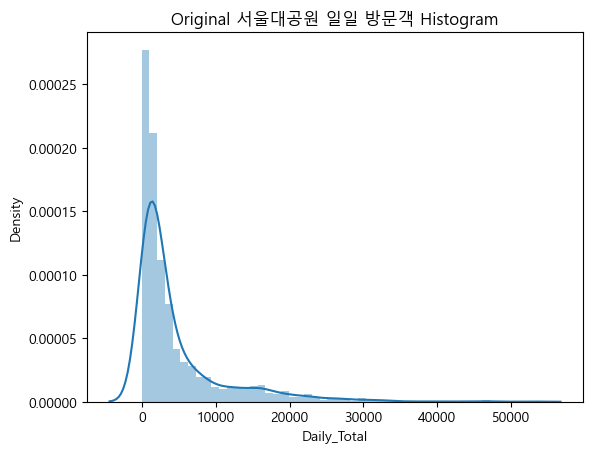

In [44]:
plt.title('Original 서울대공원 일일 방문객 Histogram')
sns.distplot(df['Daily_Total'])

- 데이터가 왼쪽으로 치우쳐져 있음(=오른 꼬리가 긴 형태)
- 로그변환 필요

<AxesSubplot:title={'center':'Log Transformed 서울대공원 일일 방문객 Histogram'}, xlabel='Daily_Total', ylabel='Density'>

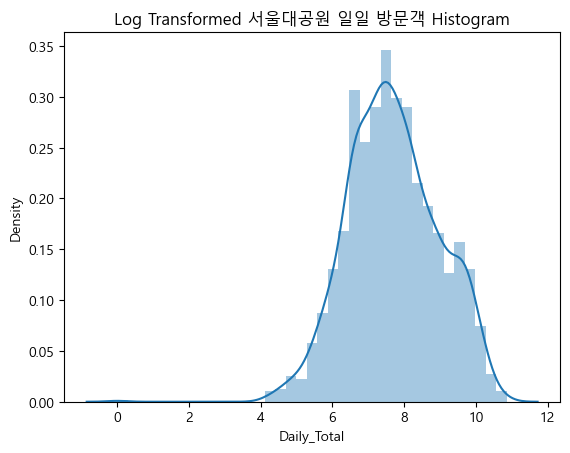

In [45]:
# 결과값을 로그 변환하고 다시 분포도 확인
plt.title('Log Transformed 서울대공원 일일 방문객 Histogram')
log_DailyTotal = np.log1p(df['Daily_Total'])
sns.distplot(log_DailyTotal)

In [46]:
# Daily_Total 로그 변환
original_DailyTotal = df['Daily_Total'] #원래값 저장
df['Daily_Total'] = np.log1p(df['Daily_Total']) #로그변환 값으로 타겟값을 대체

### 2.2. 범주형 데이터 원핫인코딩

In [47]:
# 요일, Holiday, 행사 컬럼 원핫인코딩
print('get_dummies() 수행 전 데이터 Shape:', df.shape)
df_ohe = pd.get_dummies(df, columns=['요일','Holiday','행사'])
print('get_dummies() 수행 후 데이터 Shape:', df_ohe.shape)

get_dummies() 수행 전 데이터 Shape: (1642, 14)
get_dummies() 수행 후 데이터 Shape: (1642, 22)


## 3. 선형회귀모델의 학습/예측/평가

### 3.1. 함수생성 및 데이터 분할

In [48]:
# 단일 모델의 RMSE 값 반환
def get_rmse(model): # 학습된 모델을 받아서 예측
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 여러 모델의 RMSE 값 반환
def get_rmses(models) :
    rmses = []
    for model in models :
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

# 단일 모델의 MAE 값 반환
def get_mae(model): # 학습된 모델을 받아서 예측
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test , pred)
    print('{0} 로그 변환된 MAE: {1}'.format(model.__class__.__name__,np.round(mae, 3)))
    return mae

# 여러 모델의 MAE 값 반환
def get_maes(models) :
    maes = []
    for model in models :
        mae = get_mae(model)
        maes.append(mae)
    return maes

In [49]:
## 데이터 분할
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 타깃과 피처
y_target = df_ohe['Daily_Total']
X_features = df_ohe.drop('Daily_Total',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

### 3.2. 일반모델 학습/예측/평가

In [50]:
# 일반 선형 회귀
lr_reg = LinearRegression() 
lr_reg.fit(X_train, y_train)

# 릿찌회귀
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

# 라쏘 회귀
lasso_reg=Lasso()
lasso_reg.fit(X_train,y_train)

Lasso()

In [51]:
models= [lr_reg, ridge_reg, lasso_reg]
get_rmses(models) #학습된 모델 전달하고 rmse값 반환
get_maes(models)

LinearRegression 로그 변환된 RMSE: 0.705
Ridge 로그 변환된 RMSE: 0.705
Lasso 로그 변환된 RMSE: 0.83
LinearRegression 로그 변환된 MAE: 0.513
Ridge 로그 변환된 MAE: 0.513
Lasso 로그 변환된 MAE: 0.594


[0.5132571675416334, 0.5130352575567741, 0.5940301641870229]

- Lasso 모델이 상대적으로 떨어짐
- Ridge 모델과 LR 결과는 동일하게 좋게 나옴

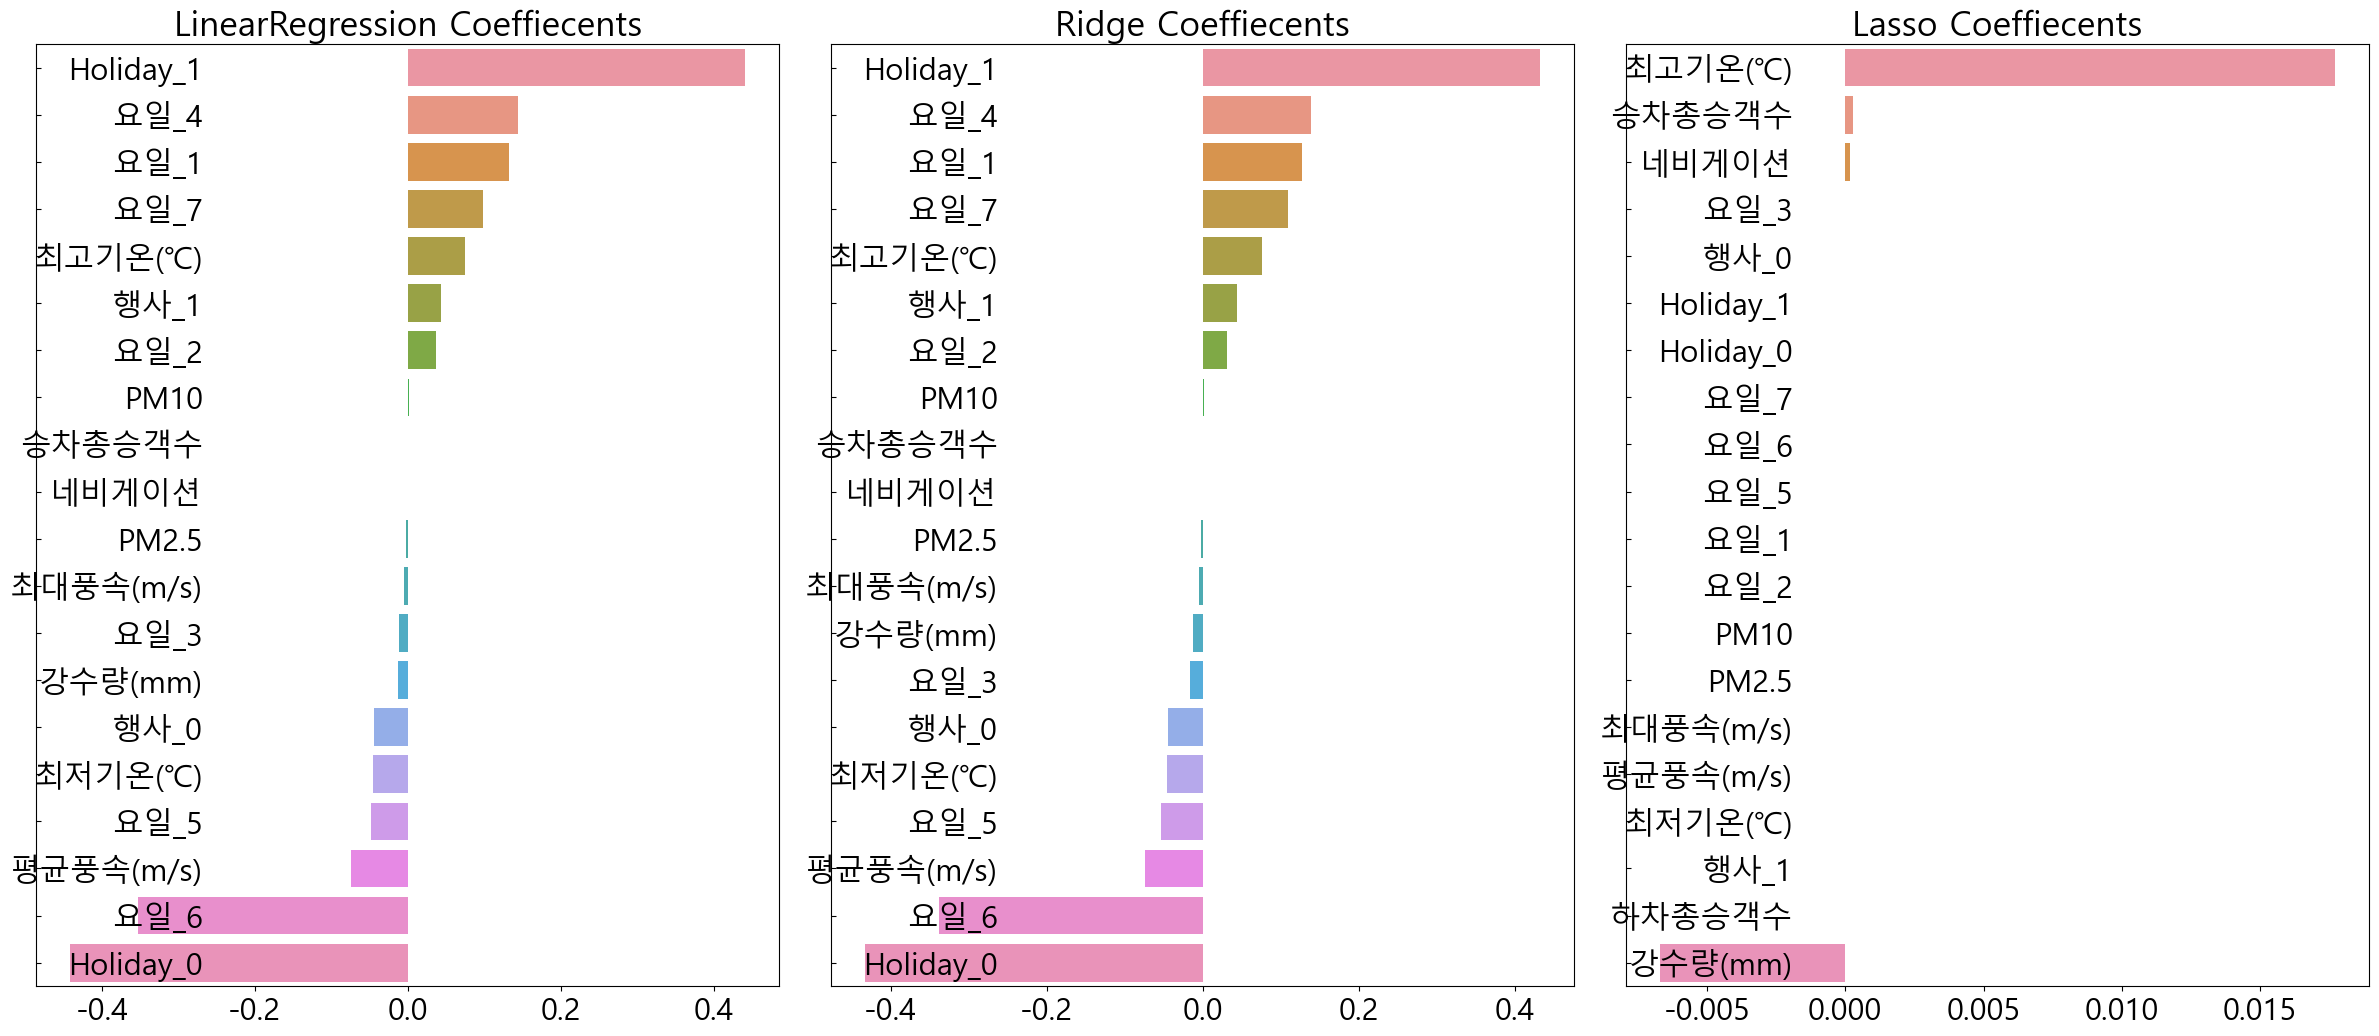

In [52]:
# 회귀계수 시각화

def get_top_bottom_coef(model) :
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    
    return coef_high, coef_low

# 모델별 회귀 계수 시각화 함수
# list 객체로 모델을 입력 받아서
# 모델별로 회귀 계수 상위 10개, 하위 10개 추출해서
# 가로 막대 그래프 형태로 출력
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__ +' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120) # 안쪽, 패딩값
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [53]:
# 결과
# OLS 기반의 LinearRegression과 Ridge : 회귀 계수가 유사한 형태로 분포
# 라쏘 : 전체적으로 회귀 계수 값이 매우 작음.
#       - 최고기온이 가장 크고, 다른 피처의 회기 계수는 너무 작음
#       - LinearRegression과 Ridge와 다른 회귀 계수 형태
# --> 혹시 학습 데이터의 분할에 문제가 있어서 그런 것인지
# 학습과 테스트 데이터 세트를 train_test_split()으로 분할하지 않고
# 전체 데이터 세트인 X_features와 y_target을 5개의 교차 검증 폴드 세트로 분할해서
# 평균 RMSE 측정해보기

### 3.3. 5 폴드 교차검정으로 모델별 RMSE, MAE 출력

In [54]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models) :
    
    for model in models :
        # 분할하지 않고 전체 데이터세트로 교차검증 수행
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))      

def get_avg_mae_cv(models) :
    
    for model in models :
        # 분할하지 않고 전체 데이터세트로 교차검증 수행
        mae_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_absolute_error", cv=5))
        mae_avg = np.mean(mae_list)
        print('\n{0} CV MAE 값 리스트: {1}'.format( model.__class__.__name__, np.round(mae_list, 3)))
        print('{0} CV 평균 MAE 값: {1}'.format( model.__class__.__name__, np.round(mae_avg, 3)))        


In [55]:
# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력           
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)
get_avg_mae_cv(models)


LinearRegression CV RMSE 값 리스트: [0.737 0.968 0.625 0.874 0.681]
LinearRegression CV 평균 RMSE 값: 0.777

Ridge CV RMSE 값 리스트: [0.736 0.967 0.625 0.874 0.681]
Ridge CV 평균 RMSE 값: 0.777

Lasso CV RMSE 값 리스트: [0.709 1.039 0.792 0.978 0.855]
Lasso CV 평균 RMSE 값: 0.874

LinearRegression CV MAE 값 리스트: [0.741 0.718 0.686 0.829 0.711]
LinearRegression CV 평균 MAE 값: 0.737

Ridge CV MAE 값 리스트: [0.741 0.718 0.686 0.83  0.711]
Ridge CV 평균 MAE 값: 0.737

Lasso CV MAE 값 리스트: [0.738 0.751 0.788 0.877 0.819]
Lasso CV 평균 MAE 값: 0.795



- 5개 폴드 세트로 학습한 후 평가해도 여전히 라쏘 모델이 다른 회귀 모델에 비해 성능이 떨어짐

#### Ridge/Lasso 모델에 대해 alpha 하이퍼 파라미터 튜닝 후 재학습/예측/평가

In [56]:
from sklearn.model_selection import GridSearchCV
# 모델과 하이퍼 파라미터 딕셔너리 객체를 받아서
# 최적화 작업의 결과를 표시하는 함수
# 릿지 모델과 라쏘 모델의 최적화 alpha 값 추출
def get_best_params_rmse(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_ # 최적 파라미터로 재학습된 모델 반환

In [57]:
ridge_params = {'alpha' : [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005, 0.008,0.05, 0.03, 0.1, 0.5, 1.5,10]}

In [58]:
best_ridge = get_best_params_rmse(ridge_reg,ridge_params)
best_lasso = get_best_params_rmse(lasso_reg,lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.7842, 최적 alpha:{'alpha': 20}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.7766, 최적 alpha:{'alpha': 0.008}


In [59]:
from sklearn.model_selection import GridSearchCV
# 모델과 하이퍼 파라미터 딕셔너리 객체를 받아서
# 최적화 작업의 결과를 표시하는 함수
# 릿지 모델과 라쏘 모델의 최적화 alpha 값 추출
def get_best_params_mae(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_absolute_error', cv=5)
    grid_model.fit(X_features, y_target)
    mae = (-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 MAE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(mae, 4), grid_model.best_params_))
    return grid_model.best_estimator_ # 최적 파라미터로 재학습된 모델 반환

In [60]:
ridge_params = {'alpha' : [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005, 0.008,0.05, 0.03, 0.1, 0.5, 1.5,10]}

In [61]:
best_ridge = get_best_params_mae(ridge_reg,ridge_params)
best_lasso = get_best_params_mae(lasso_reg,lasso_params)

Ridge 5 CV 시 최적 평균 MAE 값: 0.5453, 최적 alpha:{'alpha': 15}
Lasso 5 CV 시 최적 평균 MAE 값: 0.5443, 최적 alpha:{'alpha': 0.001}


#### 분할된 트레인/테스트세트로 학습 후 재평가

In [62]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=20)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.008)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.008)

In [63]:
# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.705
Ridge 로그 변환된 RMSE: 0.705
Lasso 로그 변환된 RMSE: 0.702


[0.7051410060456847, 0.7046451333322347, 0.7016732032555748]

In [64]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=20)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.005)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.005)

In [65]:
# 모든 모델의 MAE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_maes(models)

LinearRegression 로그 변환된 MAE: 0.513
Ridge 로그 변환된 MAE: 0.512
Lasso 로그 변환된 MAE: 0.51


[0.5132571675416334, 0.5118244084103445, 0.5104479332732391]

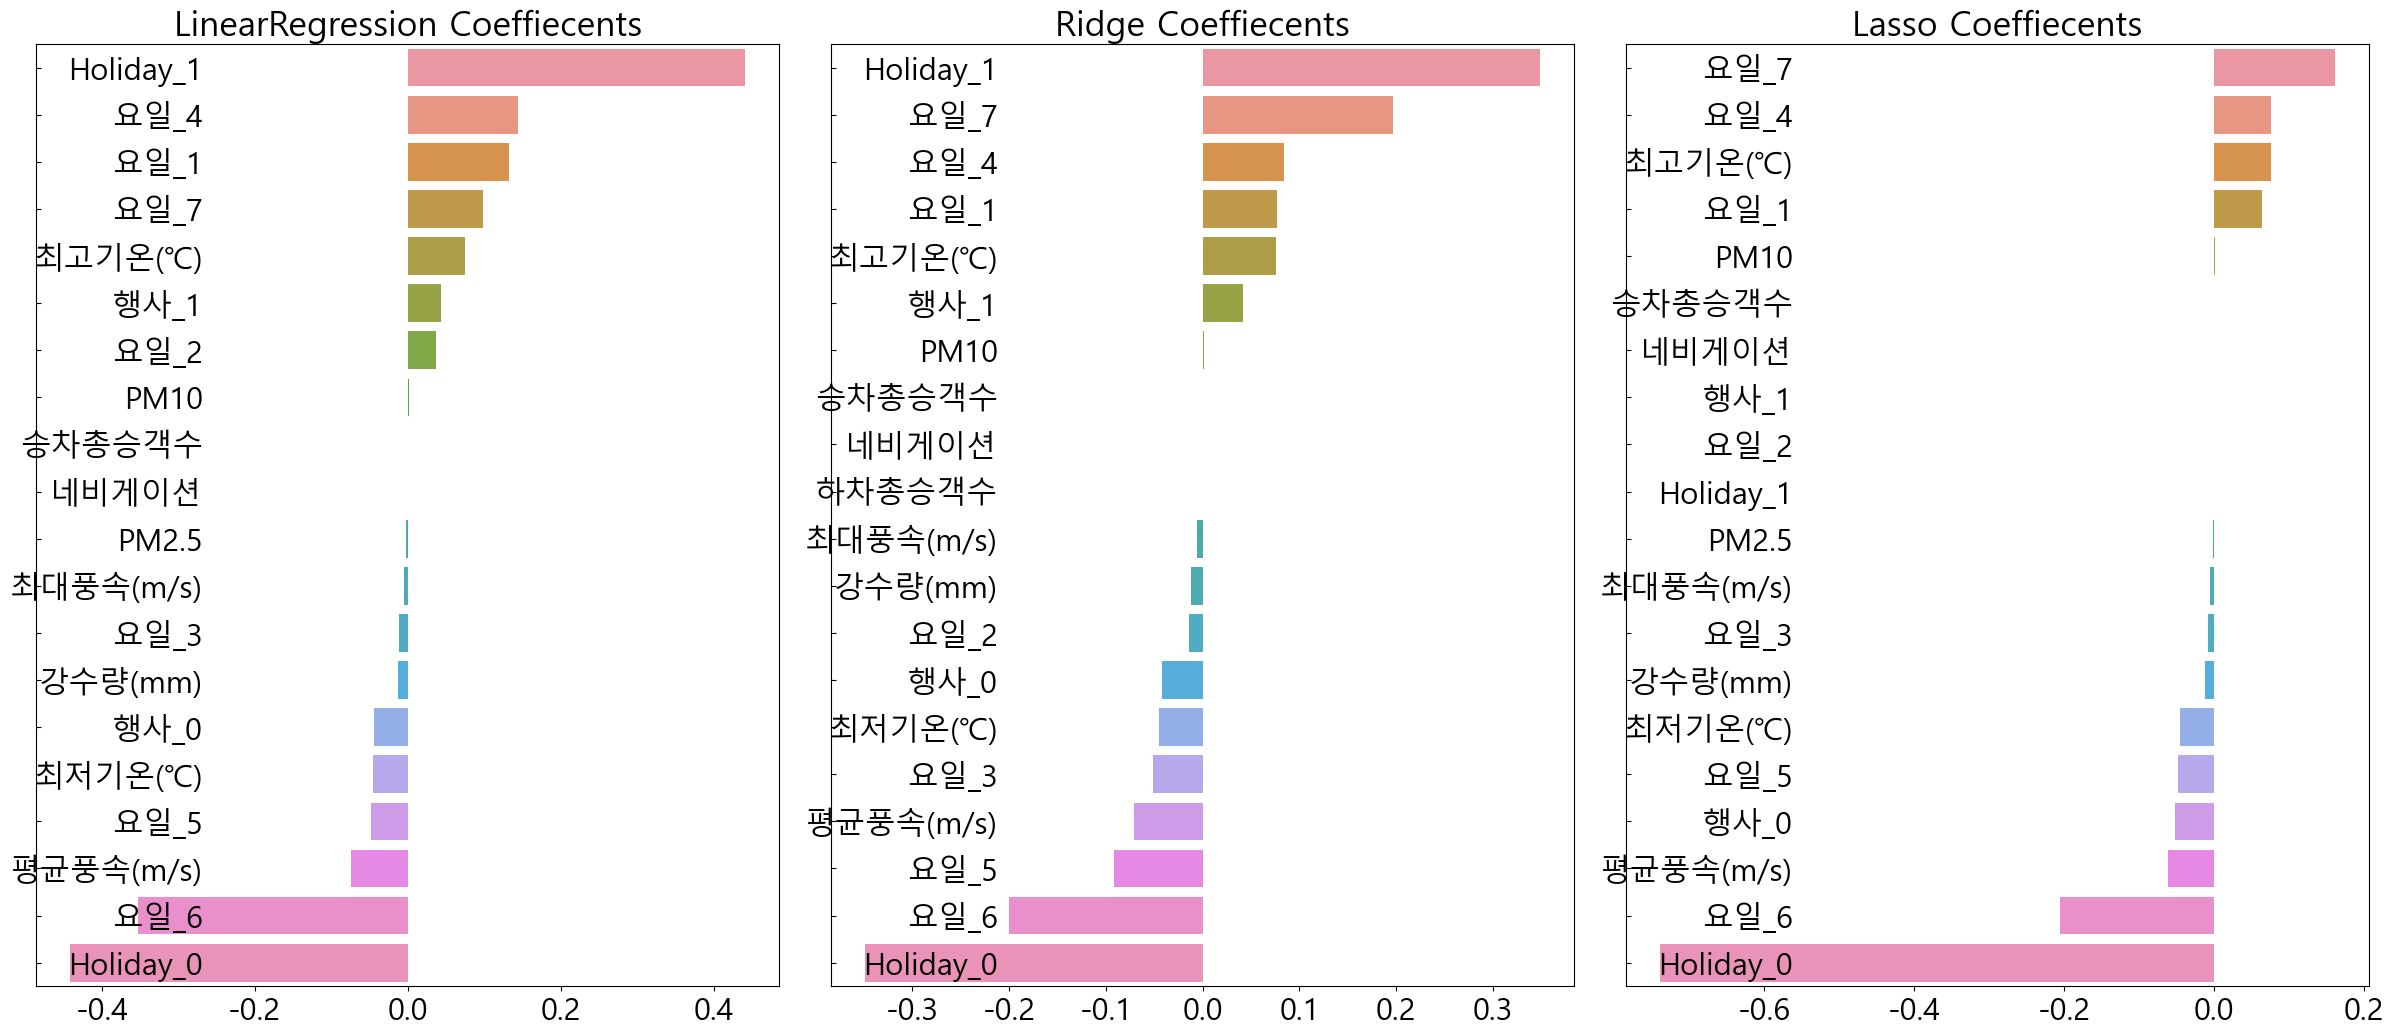

In [66]:
# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 3.4. 데이터세트 추가 가공해서 모델 튜닝 진행
- 1. 피처 데이터 세트의 데이터 분포도 확인
- 2. 이상치 데이터 처리

In [67]:
from scipy.stats import skew

features_index = ['승차총승객수', '하차총승객수', '네비게이션', '최고기온(℃)',
       '최저기온(℃)', '평균풍속(m/s)', '최대풍속(m/s)','PM2.5', 'PM10', '강수량(mm)']

In [69]:
skew_features = df[features_index].apply(lambda x:skew(x)) # 각 컬럼별로 skew() 적용 위해 apply 함수 사용
# skew_features

In [70]:
#skew 정도가 1을 초과하는 컬럼들만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

# 일반적으로 skew() 함수의 반환값이 1.5이상인 경우 왜곡도가 높다고 판단하지만 상황에 따라 편차는 있음

PM10       6.342835
강수량(mm)    6.015801
하차총승객수     3.150412
승차총승객수     2.892919
네비게이션      2.821130
PM2.5      2.336154
dtype: float64


### 3.5. 왜곡이 심한 컬럼에 로그변환 후 재학습/예측/평가

In [71]:
df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

In [72]:
# 로그 변환 후 다시 왜곡 정도를 확인해 보면
skew_features = df[features_index].apply(lambda x : skew(x))
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

# 여전히 왜곡 정도가 높은 피처가 있지만 더이상 로그변환 하더라도 개선하기 어렵다고 판단
# 그대로 유지하기로 결정

강수량(mm)    2.246488
dtype: float64


In [73]:
# Skew가 높은 피처들을 로그 변환 했으므로 
# 다시 원-핫 인코딩 적용 
# 피처/타겟 데이터 세트 다시 생성
# 최적 alpha 값과 RMSE 출력

# 원-핫 인코딩
df_ohe = pd.get_dummies(df, columns=['요일','Holiday','행사'])

# 피처/타겟 데이터 세트 다시 생성# 
y_target = df_ohe['Daily_Total']
X_features = df_ohe.drop('Daily_Total',axis=1, inplace=False)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)
# 피처 로그 변환된 data, target도 로그변환 되어 있음

In [74]:
# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

In [75]:
best_ridge = get_best_params_rmse(ridge_reg, ridge_params)
best_lasso = get_best_params_rmse(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.6322, 최적 alpha:{'alpha': 0.05}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.6325, 최적 alpha:{'alpha': 0.001}


In [76]:
best_ridge = get_best_params_mae(ridge_reg, ridge_params)
best_lasso = get_best_params_mae(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 MAE 값: 0.451, 최적 alpha:{'alpha': 0.05}
Lasso 5 CV 시 최적 평균 MAE 값: 0.4516, 최적 alpha:{'alpha': 0.005}


In [77]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=0.05)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.001)

In [78]:
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.554
Ridge 로그 변환된 RMSE: 0.553
Lasso 로그 변환된 RMSE: 0.552


[0.5538112673439908, 0.5531432449094181, 0.5521840397082706]

In [79]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=0.05)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.005)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.005)

In [80]:
models = [lr_reg, ridge_reg, lasso_reg]
get_maes(models)

LinearRegression 로그 변환된 MAE: 0.393
Ridge 로그 변환된 MAE: 0.393
Lasso 로그 변환된 MAE: 0.396


[0.3933047940457922, 0.393225130813587, 0.3963053678508562]

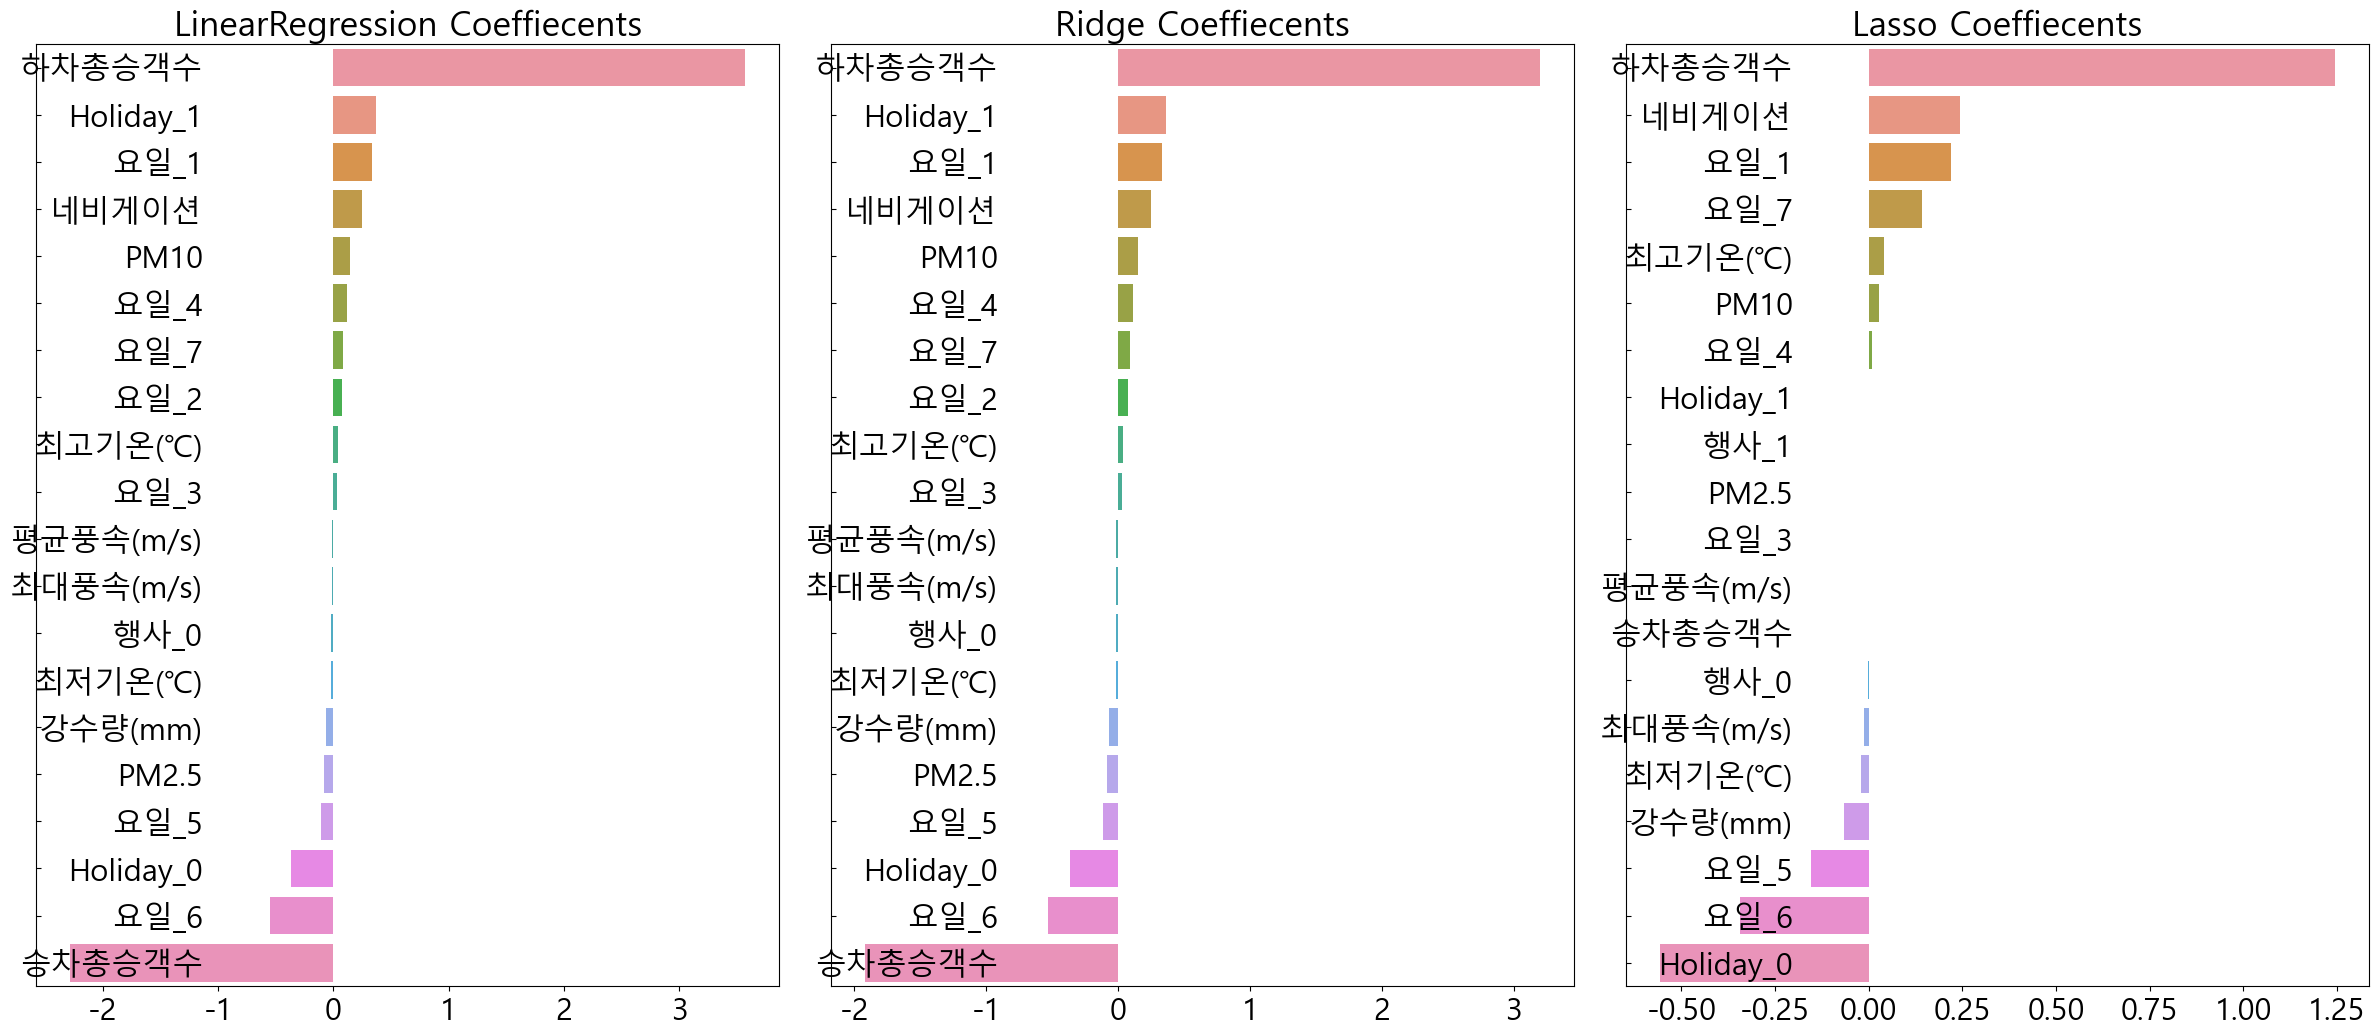

In [81]:
# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)
# 하차총승객수가 회귀계수가 가장 높은 피처가 됨

### 3.6. 이상치 제거.. 이상치가 있는데 시계열 데이터니까 제거하면 안되겠죠...

In [83]:
df_org.describe()

,요일,Daily_Total,Holiday,승차총승객수,하차총승객수,네비게이션,최고기온(℃),최저기온(℃),평균풍속(m/s),최대풍속(m/s),PM2.5,PM10,강수량(mm),행사
count,1642.000000,1642.000000,1642.000000,1642.00000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000
mean,3.996346,4628.727162,0.320341,3982.63581,4162.202192,584.009744,17.925579,8.934653,2.137515,4.542875,19.970767,40.259440,3.378502,0.216809
std,2.000301,6373.644697,0.466750,3016.43271,3160.058656,818.466432,10.550661,10.696636,0.701860,1.277147,15.828695,26.983615,12.158798,0.412197
min,1.000000,0.000000,0.000000,707.00000,750.000000,31.000000,-10.700000,-18.600000,0.600000,1.600000,1.000000,5.000000,0.000000,0.000000
25%,2.000000,886.250000,0.000000,2185.25000,2303.250000,140.000000,9.225000,0.500000,1.700000,3.600000,10.000000,25.000000,0.000000,0.000000
50%,4.000000,2043.000000,0.000000,3103.00000,3250.500000,274.000000,19.150000,8.900000,2.000000,4.400000,16.000000,36.000000,0.000000,0.000000
75%,6.000000,5203.000000,1.000000,4623.75000,4811.500000,540.000000,26.875000,18.500000,2.500000,5.300000,25.000000,49.000000,0.300000,0.000000
max,7.000000,52310.000000,1.000000,31842.00000,37928.000000,6570.000000,39.600000,30.300000,6.000000,11.800000,152.000000,534.000000,176.200000,1.000000


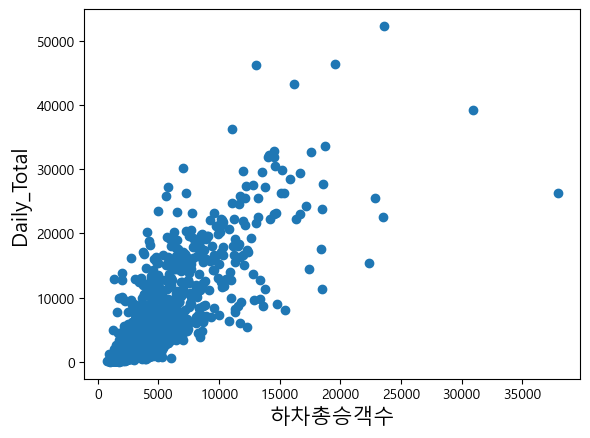

In [82]:
plt.scatter(x=df_org['하차총승객수'], y = df_org['Daily_Total']) # 원본 데이터
plt.ylabel('Daily_Total', fontsize=15)
plt.xlabel('하차총승객수', fontsize=15)
plt.show()

## 4. 가장 잘나온 모델로 exmp1 적용해서 확인
- 가장 잘나온 결과값: skew 높은 피처들 로그변환 + 타겟값 로그변환 + 요일/공휴일/행사 원핫인코딩 + train_test_split + Ridge(alpha = 0.05) 규제 사용  

In [92]:
df_org = pd.read_csv('final서울대공원1019.csv', encoding='cp949')
df_org = df_org.drop(['Unnamed: 0'], axis=1)
df_org = df_org.drop(['일자'], axis=1)
df_org = df_org.set_index('date')
df = df_org.copy()
df.head()

,요일,Daily_Total,Holiday,승차총승객수,하차총승객수,네비게이션,최고기온(℃),최저기온(℃),평균풍속(m/s),최대풍속(m/s),PM2.5,PM10,강수량(mm),행사
date,,,,,,,,,,,,,,
2018-01-01,1,2316,1,2583,2559,175,3.8,-5.1,1.4,3.8,22,39,0.0,0
2018-01-02,2,988,0,3386,3637,82,1.8,-4.3,1.8,4.9,21,35,0.0,0
2018-01-03,3,694,0,2867,3075,50,-0.4,-7.1,2.2,3.5,20,32,0.0,0
2018-01-04,4,671,0,2739,2938,58,-0.7,-8.7,1.4,3.5,27,42,0.0,0
2018-01-05,5,758,0,2985,3148,61,1.6,-5.6,1.7,3.6,34,47,0.0,0


In [ ]:
df['Daily_Total1'] = np.log1p(df['Daily_Total'])

In [87]:
y_target = df_ohe['Daily_Total']
X_features = df_ohe.drop('Daily_Total',axis=1, inplace=False)

# 로그변환된 y_target_log 반영하여 학습/테스트셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트셋의 타겟값은 로그변환되었으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타겟 기반으로 학습되어 예측되었으므로 다시 expm1로 변환
pred_exp = np.expm1(pred)

In [88]:
ridge_reg = Ridge(alpha=0.05)
ridge_reg.fit(X_train, y_train)

Ridge(alpha=0.05)

In [89]:
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.554
Ridge 로그 변환된 RMSE: 0.553
Lasso 로그 변환된 RMSE: 0.553


[0.5538112673439908, 0.5531432449094181, 0.5531330727021061]

In [90]:
models = [lr_reg, ridge_reg, lasso_reg]
get_maes(models)

LinearRegression 로그 변환된 MAE: 0.393
Ridge 로그 변환된 MAE: 0.393
Lasso 로그 변환된 MAE: 0.396


[0.3933047940457922, 0.393225130813587, 0.3963053678508562]

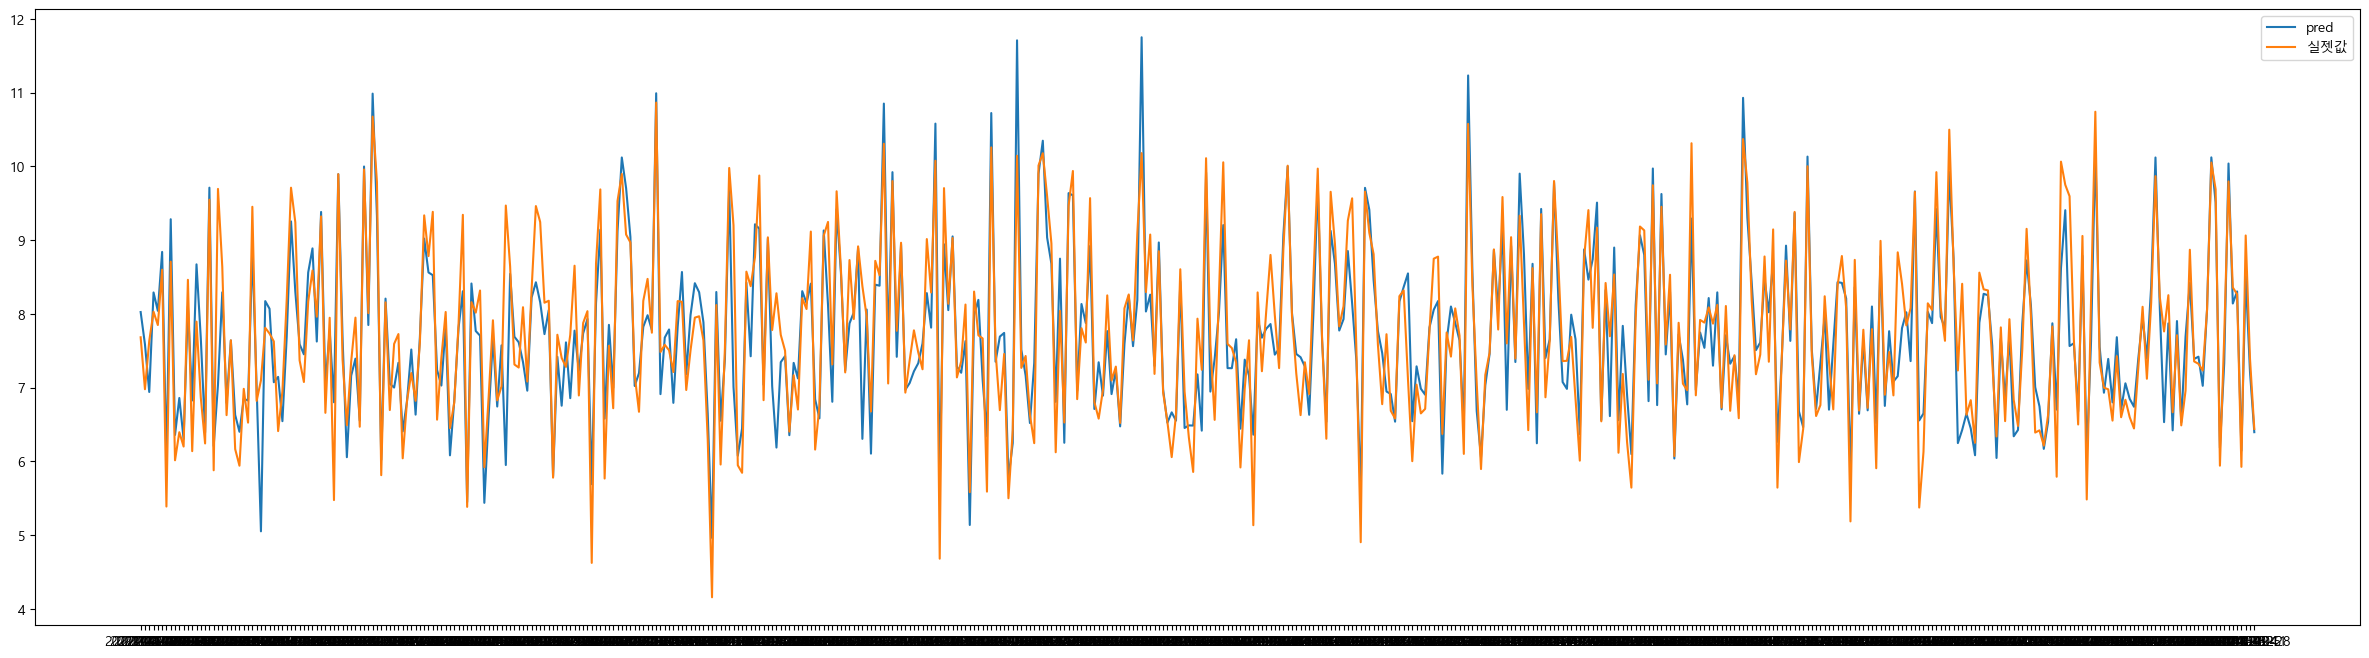

In [91]:
plt.figure(figsize=(30,8))
plt.plot(pred, label="pred")
plt.plot(y_test, label = "실젯값")
plt.legend()